In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


importing libraries

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from xgboost import XGBClassifier

file_path = '/content/drive/MyDrive/IITK/CS698Y/data.csv'

df = pd.read_csv(file_path, sep = ';')
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [24]:
df['Gender'].unique()

array([1, 0])

In [25]:
df['Nacionality'].unique()

array([  1,  62,   6,  41,  26, 103,  13,  25,  21, 101,  11,  22,  32,
       100,  24, 109,   2, 108, 105,  14,  17])

## Data Distribution across classes

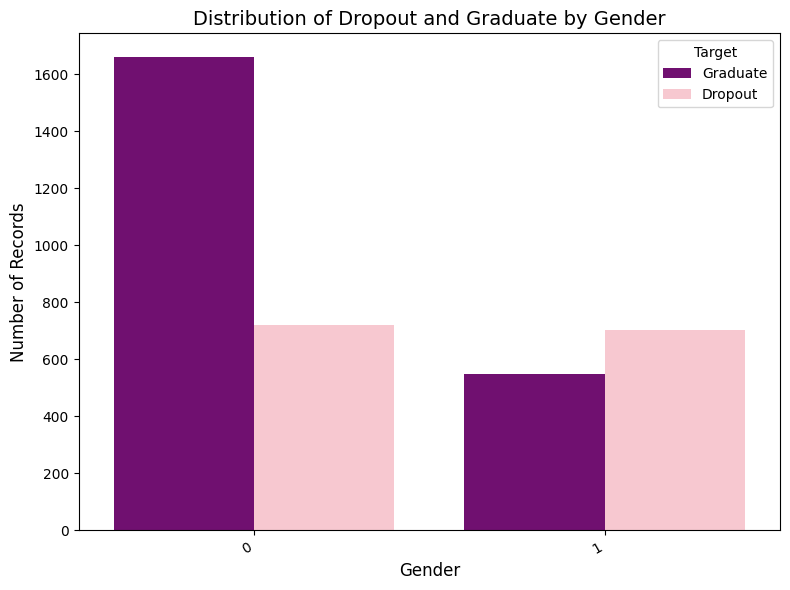

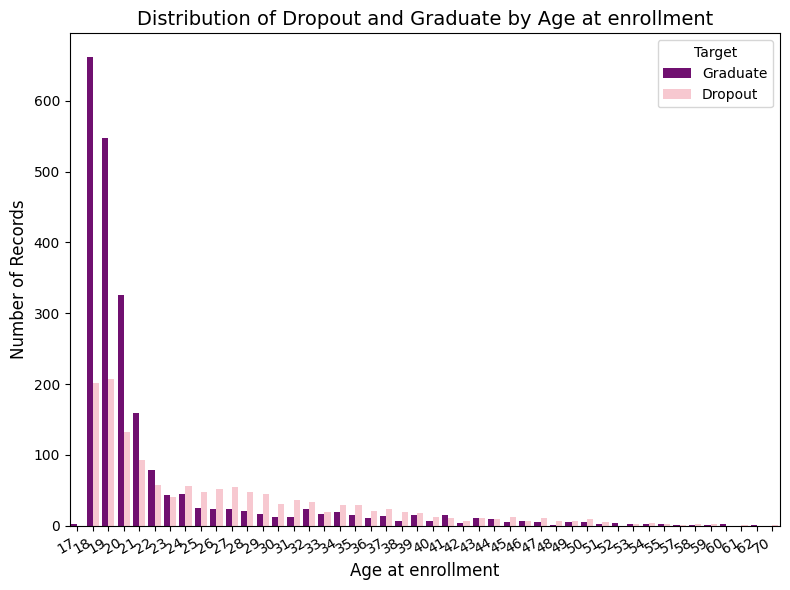

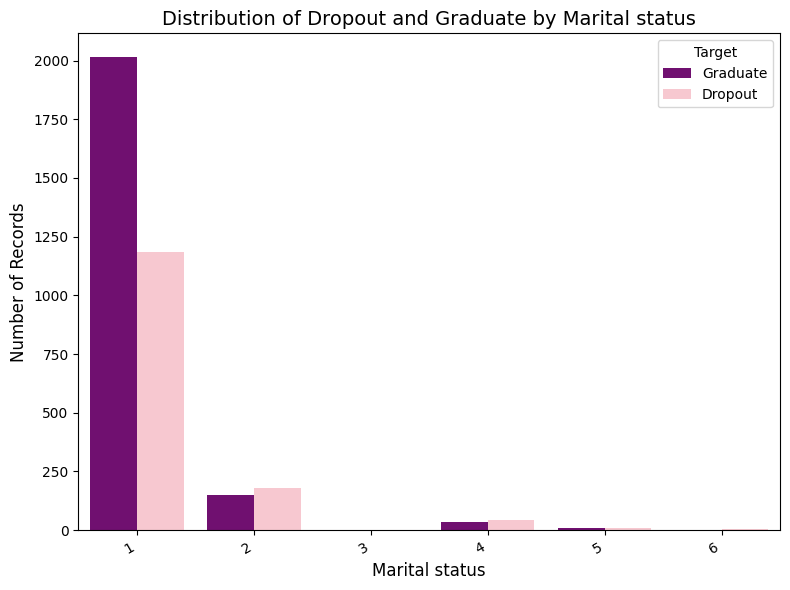

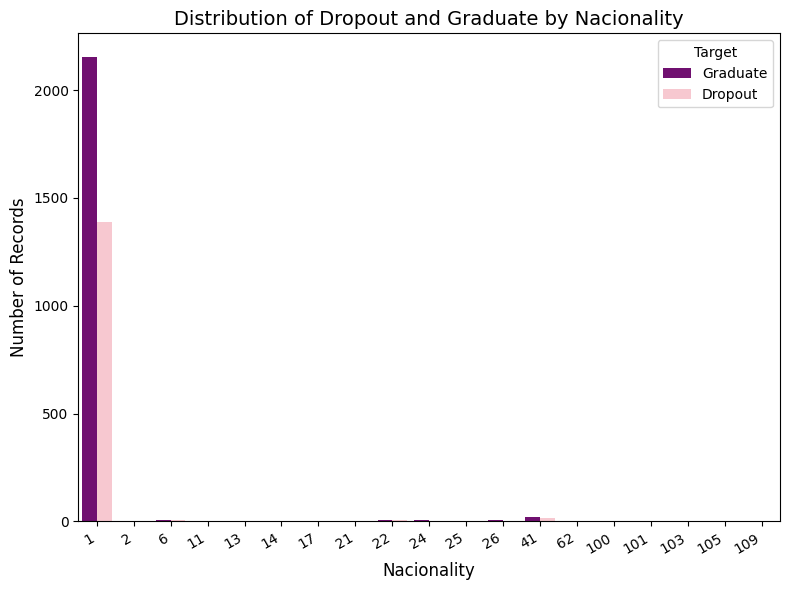

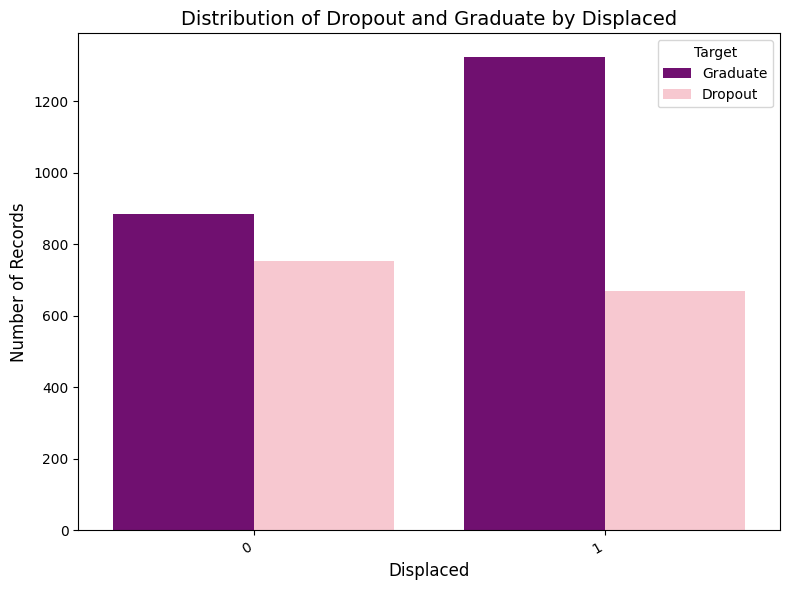

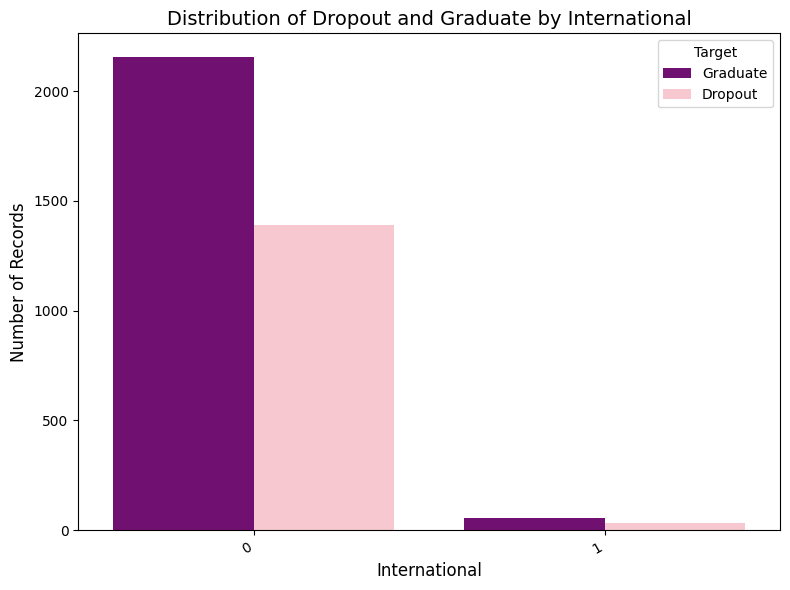

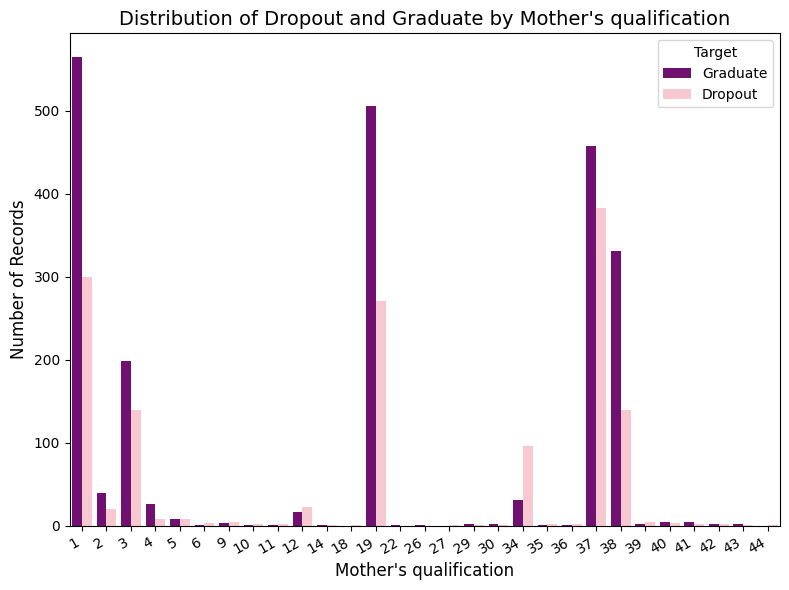

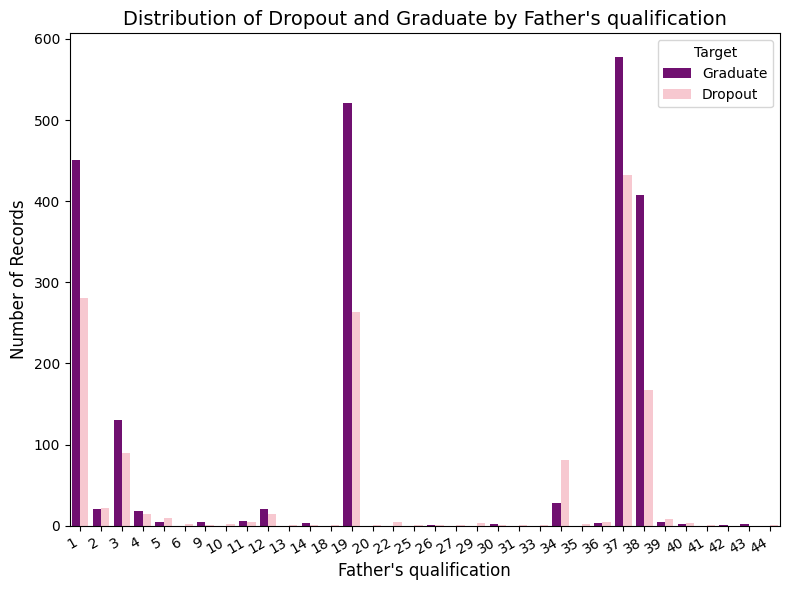

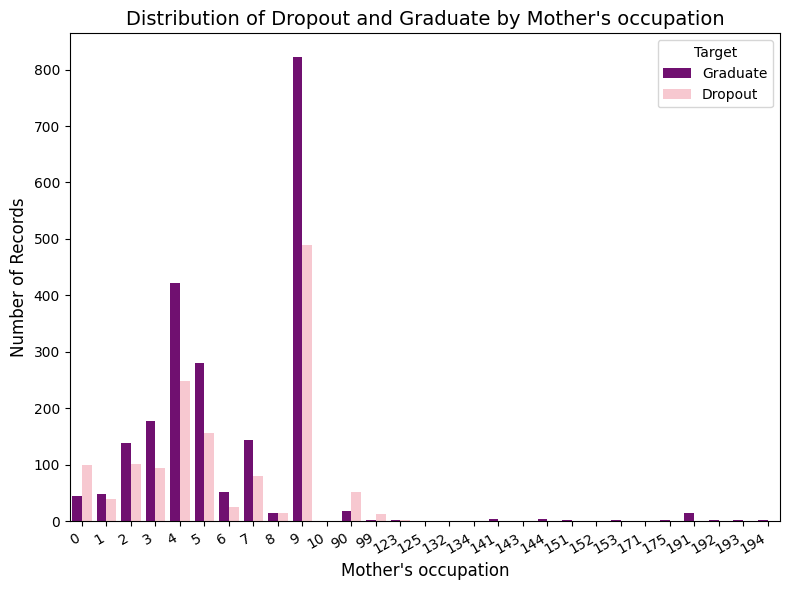

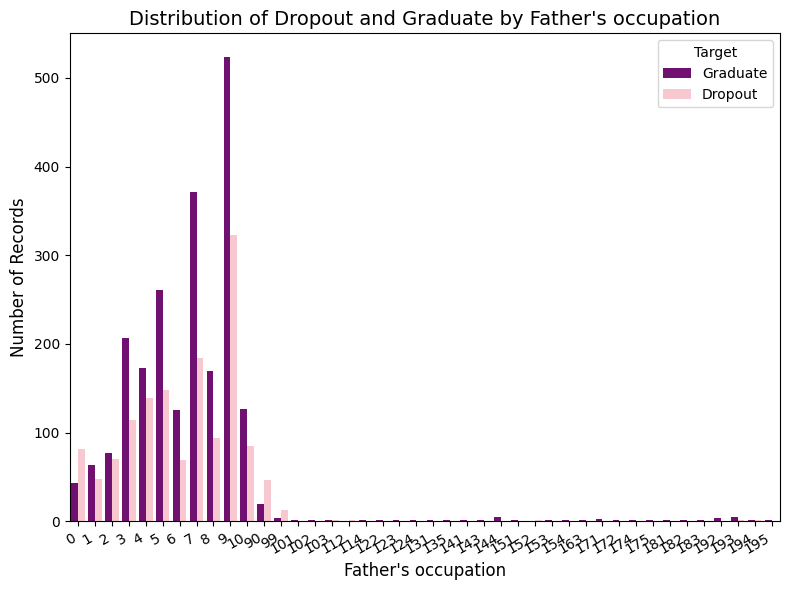

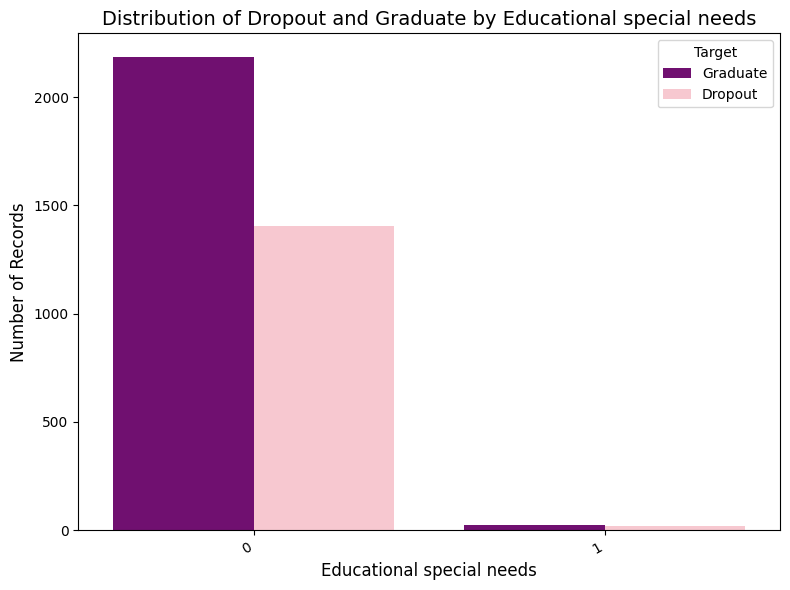

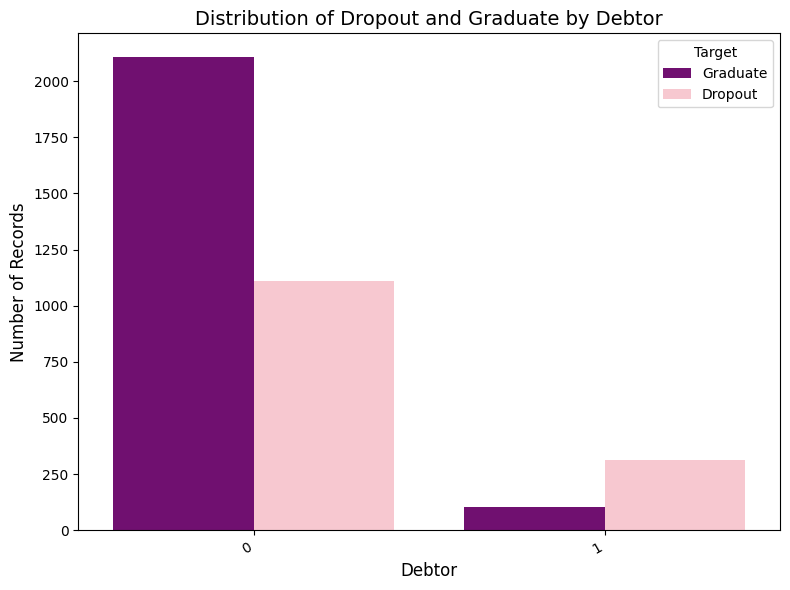

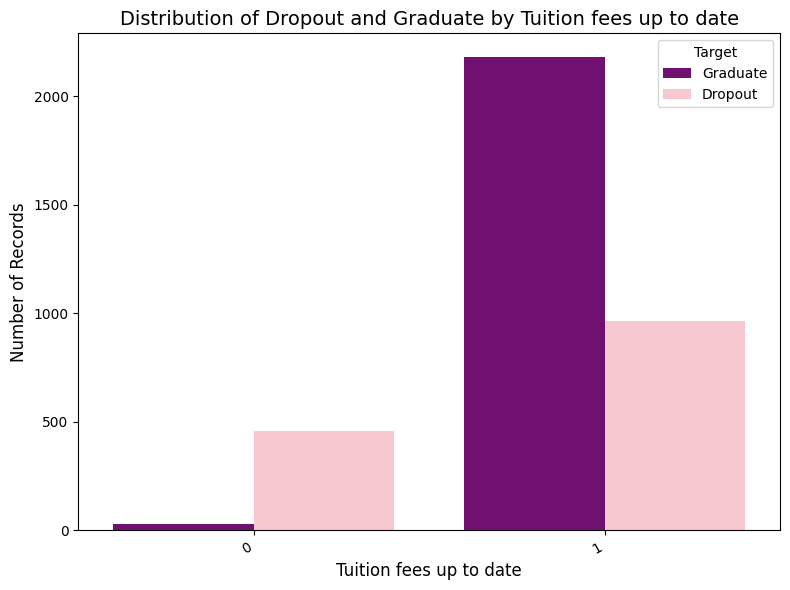

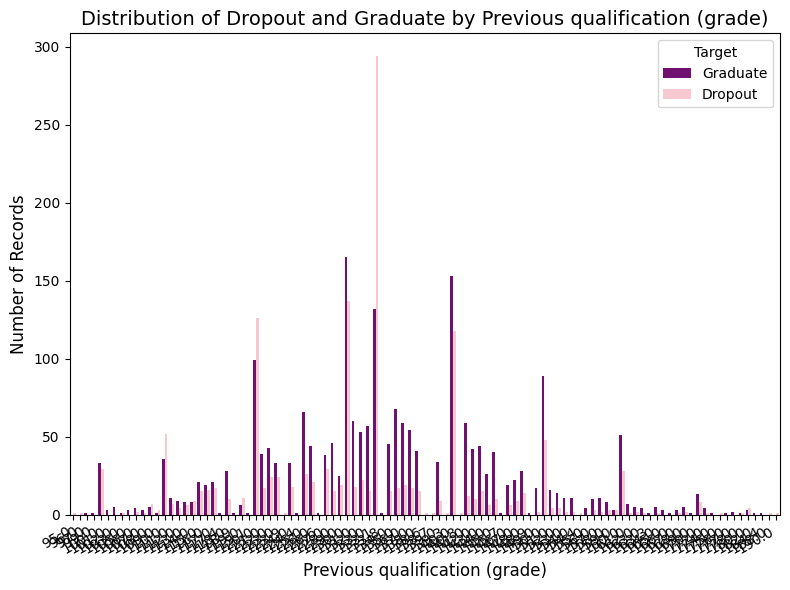

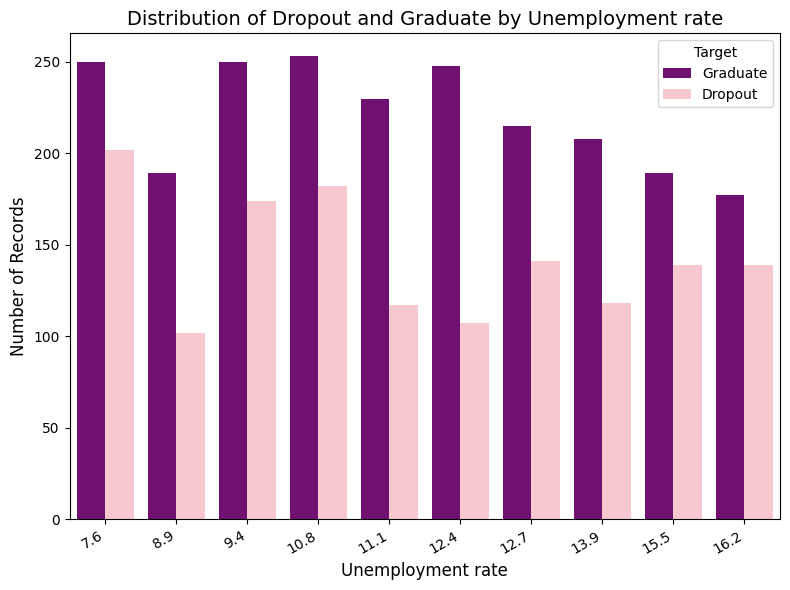

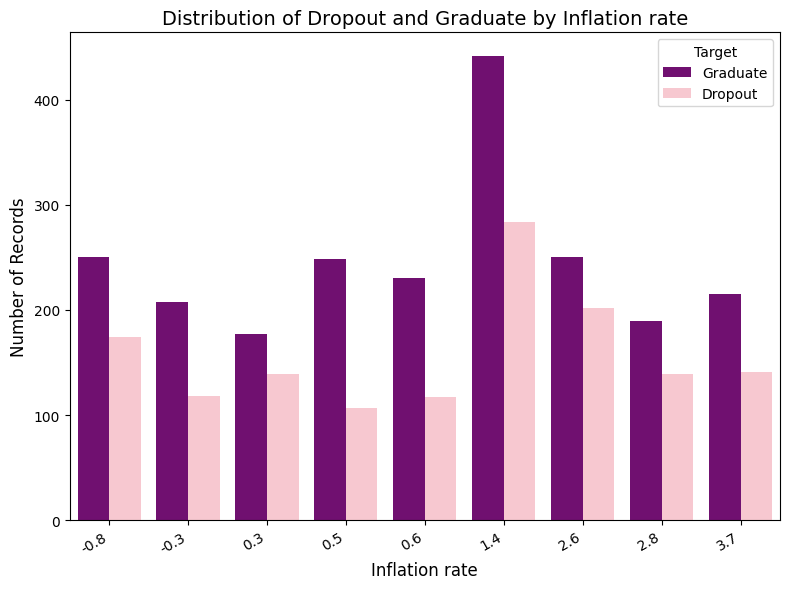

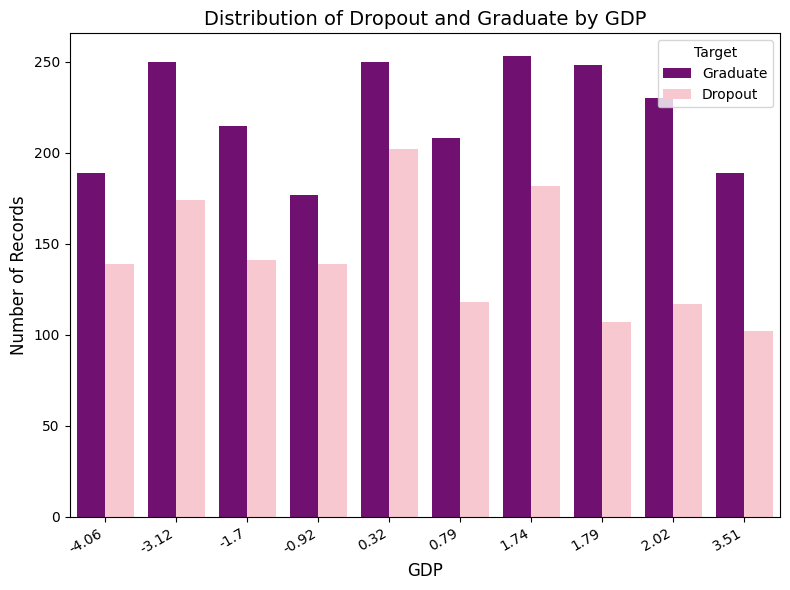

In [26]:
# Filter out 'Enrolled'
filtered_df = df[df['Target'].isin(['Dropout', 'Graduate'])]

# List of features you want to check for bias
bias_features = [
    "Gender", "Age at enrollment", "Marital status", "Nacionality",
    "Displaced", "International",
    "Mother's qualification", "Father's qualification",
    "Mother's occupation", "Father's occupation",
    "Educational special needs", "Debtor", "Tuition fees up to date",
    "Previous qualification (grade)",
    "Unemployment rate", "Inflation rate", "GDP"
]

# Fixed color palette
palette = {"Dropout": "pink", "Graduate": "purple"}

# Loop through features and plot
for feature in bias_features:
    plt.figure(figsize=(8,6))
    sns.countplot(
        data=filtered_df,
        x=feature,
        hue="Target",
        hue_order=["Graduate", "Dropout"],
        palette=palette
    )
    plt.title(f"Distribution of Dropout and Graduate by {feature}", fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Number of Records", fontsize=12)
    plt.legend(title="Target")
    plt.xticks(rotation=30, ha='right')  # rotate labels for readability
    plt.tight_layout()
    plt.show()
    plt.savefig("bias_features.jpg", dpi=300)  # one combined file
    plt.close()


Evaluating on Raw Model using K-Fold cross Validation

In [43]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
from fairlearn.metrics import demographic_parity_ratio, MetricFrame

In [44]:

# --------------------------
# 2. Drop "Enrolled" entries
# --------------------------
df = df[df['Target'].isin(['Dropout', 'Graduate'])].copy()


In [45]:

# --------------------------
# 4. Protected Features
# --------------------------

protected_features = [
    'Gender',
    'Age at enrollment',
    'Marital status',
    'Nacionality',
    'Displaced',
    'International',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    "Educational special needs",
    'Debtor',
    'Tuition fees up to date',
    'Previous qualification (grade)',
    'Unemployment rate',
    'Inflation rate',
    'GDP'
]

In [46]:
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])  # Dropout=0, Graduate=1


In [47]:
# --------------------------
# 5. Train/Test Split
# --------------------------
X_full = df.drop(columns=['Target'])
y_full = df['Target'].values


In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)


In [49]:

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X_scaled, y_full, df, test_size=0.2, random_state=42, stratify=y_full
)


In [50]:
xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    )

In [51]:




# --------------------------
# 6. K-Fold CV on Training Set
# --------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

print("==== Cross-Validation Performance & Fairness (Training Set) ====")
for train_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    df_val = df_train.iloc[val_idx]  # keep protected attributes aligned

    # Train

    xgb.fit(X_tr, y_tr)
    y_val_pred = xgb.predict(X_val)

    # Performance
    print(f"\n--- Fold {fold} ---")
    print(classification_report(y_val, y_val_pred, target_names=le.classes_))
    print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
    print(f"F1 Score: {f1_score(y_val, y_val_pred, average='weighted'):.4f}")

    # Fairness for each protected feature
    for feature in protected_features:
        if feature not in df_val.columns:
            continue

        A_val = df_val[feature].values
        mf = MetricFrame(
            metrics={'accuracy': accuracy_score,
                     'f1_score': lambda yt, yp: f1_score(yt, yp, zero_division=0)},
            y_true=y_val,
            y_pred=y_val_pred,
            sensitive_features=A_val
        )

        ratio = demographic_parity_ratio(
            y_true=y_val,
            y_pred=y_val_pred,
            sensitive_features=A_val
        )

        print(f"\nProtected Feature: {feature}")
        print(mf.by_group)
        print(f"Demographic Parity Ratio: {ratio:.2f}")
        if ratio < 0.8:
            print("Warning: Possible disparate impact (ratio < 0.8)")
        else:
            print("Fairness acceptable (ratio ≥ 0.8)")

    fold += 1

# --------------------------
# 7. Final Test Set Evaluation
# --------------------------
final_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

print("\n==== Final Test Set Performance ====")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

print("\n==== Final Test Set Fairness ====")
for feature in protected_features:
    if feature not in df_test.columns:
        continue

    A_test = df_test[feature].values
    mf = MetricFrame(
        metrics={'accuracy': accuracy_score,
                 'f1_score': lambda yt, yp: f1_score(yt, yp, zero_division=0)},
        y_true=y_test,
        y_pred=y_test_pred,
        sensitive_features=A_test
    )

    ratio = demographic_parity_ratio(
        y_true=y_test,
        y_pred=y_test_pred,
        sensitive_features=A_test
    )

    print(f"\nProtected Feature: {feature}")
    print(mf.by_group)
    print(f"Demographic Parity Ratio: {ratio:.2f}")
    if ratio < 0.8:
        print("Warning: Possible disparate impact (ratio < 0.8)")
    else:
        print("Fairness acceptable (ratio ≥ 0.8)")


==== Cross-Validation Performance & Fairness (Training Set) ====

--- Fold 1 ---
              precision    recall  f1-score   support

     Dropout       0.92      0.84      0.88       220
    Graduate       0.91      0.96      0.93       361

    accuracy                           0.91       581
   macro avg       0.91      0.90      0.90       581
weighted avg       0.91      0.91      0.91       581

Accuracy: 0.9105
F1 Score: 0.9096

Protected Feature: Gender
                     accuracy  f1_score
sensitive_feature_0                    
0                    0.931034  0.952703
1                    0.862857  0.840000
Demographic Parity Ratio: 0.60

Protected Feature: Age at enrollment
                     accuracy  f1_score
sensitive_feature_0                    
18                   0.905797  0.942731
19                   0.897638  0.935323
20                   0.941176  0.958333
21                   0.893617  0.918033
22                   0.826087  0.818182
23                   1

## Mitigating Bias

In [52]:

#  Select features & target
# -----------------------
selected_features = [
    "Application order", "Inflation rate", "Application mode", "GDP", "Unemployment rate", "Course",
    "Curricular units 1st sem (evaluations)", "Curricular units 2nd sem (evaluations)",
    "Age at enrollment", "Admission grade",
    "Curricular units 1st sem (approved)", "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (grade)", "Curricular units 2nd sem (approved)"
]


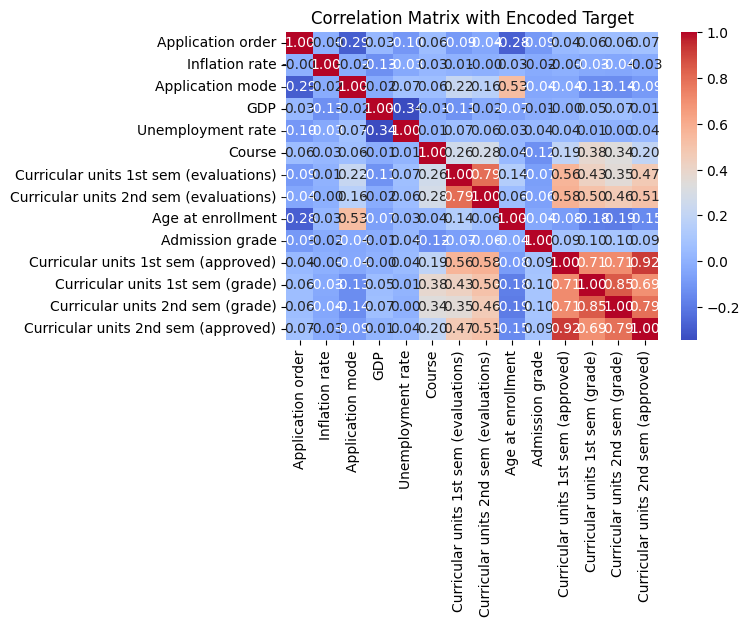

In [56]:
# Step 2: Correlation matrix
corr = df[selected_features].corr(numeric_only=True)

# Step 3: Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)

plt.title("Correlation Matrix with Encoded Target")
plt.show()

In [53]:

X = df[selected_features]
y = df["Target"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Graduate=0, Dropout=1

# -----------------------
# 2Scale features
# -----------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------
# PCA (retain 95% variance)
# -----------------------
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA reduced features from {X.shape[1]} to {X_pca.shape[1]}")

# -----------------------
#  Train-Test Split
# -----------------------
df_train, df_test, X_train, X_test, y_train, y_test = train_test_split(
    df, X_pca, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Reset index to ensure alignment
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



PCA reduced features from 14 to 11


## Model Defination with Weights

In [54]:
# Define XGBoost model with class weighting
# -----------------------
# Calculate the scale_pos_weight for the minority class ('Dropout')
n_pos = sum(y_encoded == 1) # Dropout
n_neg = sum(y_encoded == 0) # Graduate
scale_pos_weight = n_neg / n_pos

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=scale_pos_weight # Add class weighting
)

In [55]:

# -----------------------
# 7️Stratified K-Fold CV (on training set only)
# -----------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_metrics = []
fairness_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\n===== Fold {fold} =====")

    # Split using numpy indexing
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    df_val = df_train.iloc[val_idx]

    # Train
    xgb.fit(X_tr, y_tr)
    y_val_pred = xgb.predict(X_val)

    # Performance
    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred, average="weighted")
    print(f"Fold {fold} Accuracy: {acc:.4f}, F1: {f1:.4f}")

    fold_metrics.append({"fold": fold, "accuracy": acc, "f1": f1})

    # Fairness for each protected feature
    for feature in protected_features:
        if feature not in df_val.columns:
            continue

        A_val = df_val[feature].values

        # Group metrics
        mf = MetricFrame(
            metrics={"accuracy": accuracy_score,
                     "f1_score": lambda yt, yp: f1_score(yt, yp, zero_division=0)},
            y_true=y_val,
            y_pred=y_val_pred,
            sensitive_features=A_val
        )

        # Statistical parity using ratio
        ratio = demographic_parity_ratio(
            y_true=y_val,
            y_pred=y_val_pred,
            sensitive_features=A_val
        )

        fairness_results.append({
            "fold": fold,
            "feature": feature,
            "accuracy_by_group": mf.by_group["accuracy"].to_dict(),
            "f1_by_group": mf.by_group["f1_score"].to_dict(),
            "demographic_parity_ratio": ratio
        })

        print(f"\n--- Feature: {feature} ---")
        print(mf.by_group)
        print(f"Demographic Parity Ratio: {ratio:.2f}")

# -----------------------
# Final Model on Full Train Set
# -----------------------
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)

print("\n==== Final Test Set Performance (20% held-out) ====")
print(classification_report(y_test, y_pred_test))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred_test, average='weighted'):.4f}")


===== Fold 1 =====
Fold 1 Accuracy: 0.8623, F1: 0.8606

--- Feature: Gender ---
                     accuracy  f1_score
sensitive_feature_0                    
0                    0.860590  0.902985
1                    0.865385  0.858586
Demographic Parity Ratio: 0.70

--- Feature: Age at enrollment ---
                     accuracy  f1_score
sensitive_feature_0                    
17                   1.000000  1.000000
18                   0.873134  0.921659
19                   0.830645  0.881356
20                   0.897436  0.929825
21                   0.882353  0.916667
22                   0.909091  0.933333
23                   0.941176  0.947368
24                   0.944444  0.909091
25                   0.800000  0.571429
26                   0.818182  0.800000
27                   0.900000  0.888889
28                   0.916667  0.800000
29                   0.888889  0.857143
30                   0.800000  0.666667
31                   0.800000  0.800000
32          